In [1]:
%load_ext autoreload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys,os, pathlib
current = pathlib.Path(os.getcwd())
base = current.parent.parent
catenc = base.joinpath('categorical-encoding')
sys.path.append(str(catenc))

# Binary classification problem



In [3]:
rs_split = 8379
rs_enc = 1179
rs_rf = 5991
n_samples = 10000

In [4]:
from sklearn.datasets import make_classification
X_h, y_h = make_classification(n_samples = n_samples, n_features=10, n_informative=5, n_redundant=0, 
                               class_sep = 0.01, random_state=2834)

In [5]:
#Now convert the last column to the categorical
from sklearn.preprocessing import KBinsDiscretizer
disczr1 = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
cat_column1 = disczr1.fit_transform(X_h[:,-1].reshape(-1, 1)) * 193 % 20 #We want to break the monotonicity
disczr2 = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='uniform')
cat_column2 = disczr2.fit_transform(X_h[:,-2].reshape(-1, 1)) * 173 % 20 #We want to break the monotonicity

In [6]:
predictors = pd.DataFrame(X_h[:, 0:-2], columns=[f'col_{i}' for i in range(8)])
predictors['cat1'] = cat_column1
predictors['cat2'] = cat_column2
#predictors['cat1_orig'] = cat_column1
#predictors['cat2_orig'] = cat_column2
predictors.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,cat1,cat2
0,-0.487295,-0.147595,0.702684,-0.980724,-2.212259,-0.705400,1.487825,0.482706,16.0,18.0
1,0.639721,-1.635640,0.643382,0.953232,-0.178569,0.332062,2.076369,-0.756664,16.0,11.0
2,-0.894759,1.810931,1.427439,-0.638438,2.661236,-0.263417,1.359360,-0.759298,16.0,10.0


In [7]:
y_h[y_h<0] = 0

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=rs_split)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
model = RandomForestClassifier(n_estimators=100, max_depth=2, max_features=3, min_samples_leaf=1,
                               random_state=rs_rf, n_jobs=-1) 
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:,1]

print('Train accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Test accuracy: ', accuracy_score(y_test, preds.round()))
print('AUC: ', roc_auc_score(y_test, preds))

Train accuracy:  0.68975
Test accuracy:  0.6735
AUC:  0.7250086016859303


In [10]:
model.feature_importances_

array([0.00766255, 0.12502227, 0.20512611, 0.18482931, 0.01124271,
       0.4187756 , 0.00490739, 0.0112219 , 0.        , 0.03121215])

OK, Now we will try to use the probabilistic target encoder


## Cross-validation

We really should use cross-validation to avoid overfitting

### Cross-validation of the target encoding model

First we will train a model using target encoding

In [14]:
%%time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
import optuna
from optuna.distributions import *

loo = LeaveOneOutEncoder(cols=['cat1', 'cat2'], sigma=0.05, random_state=2834)
rf = RandomForestClassifier(n_estimators=400, random_state=2834, n_jobs=-1) 
pipe = Pipeline(steps=[('loo',loo), ('rf',rf)])

param_distribution = {
    'loo__sigma': LogUniformDistribution(1E-5, 1E-1),
    'rf__max_depth': IntUniformDistribution(5,40),
    'rf__max_features' : IntUniformDistribution(1,10),
    'rf__min_samples_leaf': IntUniformDistribution(1,3)
}

X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

search = optuna.integration.OptunaSearchCV(pipe, param_distribution, 
                                           cv=5, n_jobs=-1, random_state=514, timeout= 5*60, scoring='accuracy')

search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


C:\Users\michael.larionov\AppData\Local\Continuum\anaconda3\envs\cat_enc\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[I 2020-05-14 11:26:01,121] Finished trial#8 with value: 0.640125 with parameters: {'loo__sigma': 3.26601115505556e-05, 'rf__max_depth': 10, 'rf__max_features': 3, 'rf__min_samples_leaf': 2}. Best is trial#8 with value: 0.640125.
[I 2020-05-14 11:26:01,416] Finished trial#3 with value: 0.7532500000000001 with parameters: {'loo__sigma': 0.023134332310978896, 'rf__max_depth': 13, 'rf__max_features': 1, 'rf__min_samples_leaf': 1}. Best is trial#3 with value: 0.7532500000000001.
[I 2020-05-14 11:26:01,611] Finished trial#5 with value: 0.514500

Best parameter (CV score=0.794):
{'loo__sigma': 0.0399969357010434, 'rf__max_depth': 22, 'rf__max_features': 6, 'rf__min_samples_leaf': 1}
Wall time: 1min 5s


In [15]:
test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))

Test accuracy:  0.7925


### Cross-validation of the probabilistic encoder

First we create a class that makes it easier for us to run sklearn cross validation

In [16]:
from category_encoders.posterior_imputation_bc import PosteriorImputationEncoderBC  
from category_encoders.pte_utils import EncoderWrapper

In [21]:
%%time
from sklearn.model_selection import cross_val_score

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], n_draws=5, random_state=2834, prior_samples_ratio=0)
model = RandomForestClassifier(n_estimators=400, max_depth=30, max_features=1, 
                               random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_distribution = {
    'encoder__prior_samples_ratio': LogUniformDistribution(1E-9, 1E-5),
    'encoder__n_draws': IntUniformDistribution(1,40),
    'encoder__leave_one_out': CategoricalDistribution([False, True]),
    'classifier__max_depth': IntUniformDistribution(5,40),
    'classifier__max_features' : IntUniformDistribution(1,10),
    'classifier__min_samples_leaf': IntUniformDistribution(1,5)
}


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

search = optuna.integration.OptunaSearchCV(wrapper_model, param_distribution, 
                                           cv=5, n_jobs=-1, random_state=514, timeout= 30*60, scoring='accuracy')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

[I 2020-05-14 12:00:47,626] Finished trial#5 with value: 0.7859999999999999 with parameters: {'encoder__prior_samples_ratio': 1.0219421774514838e-07, 'encoder__n_draws': 4, 'encoder__leave_one_out': False, 'classifier__max_depth': 15, 'classifier__max_features': 8, 'classifier__min_samples_leaf': 4}. Best is trial#5 with value: 0.7859999999999999.
[I 2020-05-14 12:02:16,438] Finished trial#1 with value: 0.78975 with parameters: {'encoder__prior_samples_ratio': 1.7390727657842863e-08, 'encoder__n_draws': 15, 'encoder__leave_one_out': False, 'classifier__max_depth': 13, 'classifier__max_features': 3, 'classifier__min_samples_leaf': 5}. Best is trial#1 with value: 0.78975.
[I 2020-05-14 12:02:56,357] Finished trial#7 with value: 0.788625 with parameters: {'encoder__prior_samples_ratio': 2.1337212146785846e-09, 'encoder__n_draws': 4, 'encoder__leave_one_out': True, 'classifier__max_depth': 20, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 4}. Best is trial#1 with value: 0.

Best parameter (CV score=0.794):
{'encoder__prior_samples_ratio': 1.60207280240633e-07, 'encoder__n_draws': 6, 'encoder__leave_one_out': True, 'classifier__max_depth': 32, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 2}
Wall time: 13min 10s


In [22]:
test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))

Test accuracy:  0.7955


### Study how hyperparameters influence the model performance

#### Leave one out or not?

In [44]:
from sklearn.model_selection import GridSearchCV
pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                                   n_draws=search.best_params_['encoder__n_draws'], 
                                   random_state=2834, 
                                   prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                                   leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                               max_depth=search.best_params_['classifier__max_depth'], 
                               max_features=search.best_params_['classifier__max_features'], 
                               min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                               random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)


search1 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__leave_one_out' : [False, True]})

search1.fit(X_train, y_train)
print(search1.cv_results_['mean_test_score'])
print(search1.cv_results_['std_test_score'])

GridSearchCV(cv=None, error_score=nan,
             estimator=EncoderWrapper(classifier=RandomForestClassifier(bootstrap=True,
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                        max_depth=32,
                                                                        max_features=4,
                                                                        max_leaf_nodes=None,
                                                                        max_samples=None,
                                                                        min_impurity_decrease=0.0,
                                                                        min_impurity_split=None,
                                                    

array([0.00691014, 0.00989476])

[0.788    0.790625 0.791625 0.794    0.795    0.7935   0.791125 0.792875
 0.7915   0.78975  0.790625 0.790875 0.78825  0.792    0.788375 0.790875
 0.78975  0.788375 0.786125 0.78875  0.788625 0.7875   0.787375 0.787375
 0.785875 0.786    0.7865   0.787    0.787375 0.786    0.789    0.787875
 0.789375 0.786    0.785    0.786875 0.78825  0.785875]
Wall time: 1h 1min 36s


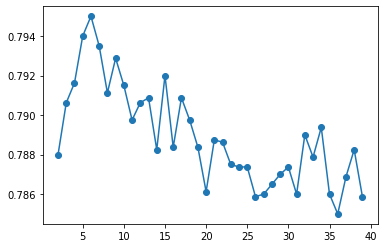

In [48]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range = range(2, 40)
search2 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__n_draws' : param_range})

search2.fit(X_train, y_train)
results = search2.cv_results_['mean_test_score']    
    
print(results)
plt.plot(list(param_range), results, '-o')
plt.plot(list(param_range), results + search2.cv_results_['std_test_score'] , '-o');
plt.plot(list(param_range), results - search2.cv_results_['std_test_score'] , '-o');
plt.show();

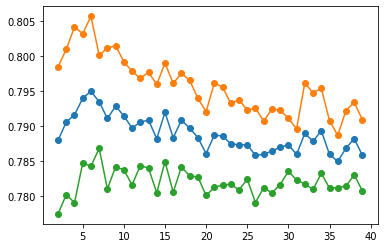

In [53]:
plt.plot(list(param_range), results, '-o')
plt.plot(list(param_range), results + search2.cv_results_['std_test_score'] , '-o');
plt.plot(list(param_range), results - search2.cv_results_['std_test_score'] , '-o');
plt.show();

[0.795    0.796125 0.792875 0.79125  0.7925   0.791375 0.79275  0.787
 0.79025 ]


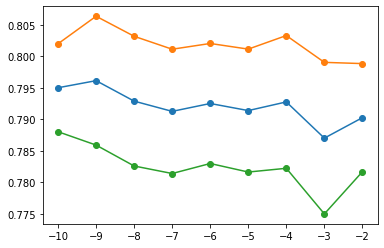

Wall time: 4min 14s


In [54]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range =  range(-10, -1)
search3 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__prior_samples_ratio' : [10**i for i in param_range]})

search3.fit(X_train, y_train)
    
results = search3.cv_results_['mean_test_score']    
    
print(results)
plt.plot(list(param_range), results, '-o')
plt.plot(list(param_range), results + search3.cv_results_['std_test_score'] , '-o');
plt.plot(list(param_range), results - search3.cv_results_['std_test_score'] , '-o');
plt.show();